In [2]:
 pip install MetaTrader5

In [1]:
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import MetaTrader5 as mt5
import time

In [2]:
# подключимся к MetaTrader 5
if not mt5.initialize():
    print("initialize() failed")
    mt5.shutdown()

In [3]:
#Получим тики EURRUB и USDRUB со вчерашнего дня по сегодняшний день
eurrub_ticks = mt5.copy_ticks_range("EURRUB", 
                                     datetime.now() - timedelta(days=1), 
                                     datetime.now(), 
                                     mt5.COPY_TICKS_ALL)

usdrub_ticks = mt5.copy_ticks_range("USDRUB", 
                                     datetime.now() - timedelta(days=1), 
                                     datetime.now(), 
                                     mt5.COPY_TICKS_ALL)

In [4]:
# Завершим подключение
mt5.shutdown()

True

In [5]:
#Переведем имеющиеся у нас данные в DataFrame
eurrub_ticks_frame = pd.DataFrame(eurrub_ticks)
usdrub_ticks_frame = pd.DataFrame(usdrub_ticks)
#Время в MetaTrader 5 хранится в UTC таймзоне, поэтому переведем в привычный нам вид
eurrub_ticks_frame['time']=pd.to_datetime(eurrub_ticks_frame['time'], unit='s')
usdrub_ticks_frame['time']=pd.to_datetime(usdrub_ticks_frame['time'], unit='s')

#Удалим ненужные столбцы
eurrub_ticks_frame.drop('ask', axis = 1, inplace = True)
eurrub_ticks_frame.drop('flags', axis = 1, inplace = True)
eurrub_ticks_frame.drop('volume_real', axis = 1, inplace = True)
eurrub_ticks_frame.drop('last', axis = 1, inplace = True)
eurrub_ticks_frame.drop('volume', axis = 1, inplace = True)

usdrub_ticks_frame.drop('bid', axis = 1, inplace = True)
usdrub_ticks_frame.drop('flags', axis = 1, inplace = True)
usdrub_ticks_frame.drop('volume_real', axis = 1, inplace = True)
usdrub_ticks_frame.drop('last', axis = 1, inplace = True)
usdrub_ticks_frame.drop('volume', axis = 1, inplace = True)
#eurrub_ticks_frame['time_msc']=pd.to_datetime(eurrub_ticks_frame['time_msc'], unit='ms')
#usdrub_ticks_frame['time_msc']=pd.to_datetime(usdrub_ticks_frame['time_msc'], unit='ms')

In [6]:
eurrub_ticks_frame

,time,bid,time_msc
0,2020-12-08 12:00:16,88.6528,1607428816026
1,2020-12-08 12:00:16,88.6538,1607428816623
2,2020-12-08 12:00:16,88.6519,1607428816930
3,2020-12-08 12:00:17,88.6516,1607428817335
4,2020-12-08 12:00:18,88.6513,1607428818436
...,...,...,...
54080,2020-12-09 12:00:13,89.1463,1607515213134
54081,2020-12-09 12:00:14,89.1408,1607515214500
54082,2020-12-09 12:00:14,89.1378,1607515214811
54083,2020-12-09 12:00:15,89.1385,1607515215241


In [7]:
usdrub_ticks_frame

,time,ask,time_msc
0,2020-12-08 12:00:17,73.3548,1607428817225
1,2020-12-08 12:00:17,73.3538,1607428817525
2,2020-12-08 12:00:18,73.3538,1607428818541
3,2020-12-08 12:00:18,73.3518,1607428818842
4,2020-12-08 12:00:19,73.3518,1607428819144
...,...,...,...
65325,2020-12-09 12:00:14,73.7318,1607515214603
65326,2020-12-09 12:00:14,73.7288,1607515214904
65327,2020-12-09 12:00:15,73.7288,1607515215205
65328,2020-12-09 12:00:16,73.7278,1607515216259


In [8]:
position_euro = 0
position_usd = 0
old_euro = eurrub_ticks_frame['bid'][0]
old_usd = usdrub_ticks_frame['ask'][0]
current_usd = old_usd
current_euro = old_euro

spread = []

while(position_euro <= len(eurrub_ticks_frame['time'])):
    
    if(eurrub_ticks_frame['time_msc'][position_euro] >= usdrub_ticks_frame['time_msc'][position_usd]):
        
        current_usd = usdrub_ticks_frame['ask'][position_usd]
        spread.append(current_euro - current_usd)
        old_usd = usdrub_ticks_frame['ask'][position_usd]
        if position_usd >= len(usdrub_ticks_frame['time']) - 1:
            break
        position_usd += 1
    else:
        
        current_euro = eurrub_ticks_frame['bid'][position_euro]
        spread.append(current_euro - old_usd)
        if position_euro >= len(eurrub_ticks_frame['time']) - 1:
            break
        position_euro += 1
    
        

In [9]:
len(spread)

119413

In [10]:
#максимальное и минимальное значение
max_spread = max(spread)
min_spread = min(spread)

In [11]:
#Найдём медиану
spread = np.array(spread)
type(spread)
median = np.median(spread)
median

15.3784

In [12]:
max_spread

15.599199999999996

In [13]:
min_spread

15.224899999999991

In [15]:
Open = median + (max_spread - median) * 0.8
print(Open)
Close = median + (min_spread - median) * 0.8
print(Close)

15.555039999999996
15.255599999999992


In [ ]:
def open_pos():
    request = {
    "action": mt5.TRADE_ACTION_DEAL, # Совершить сделку прямо сейчас
    "symbol": "USDRUB", # Сделка USDRUB
    "volume": lot, # Объем который мы покупаем
    "type": mt5.ORDER_TYPE_BUY, # Покупаем или продаём
    "price": price, 
    "sl": price - 100 * point,
    "tp": price + 100 * point,
    "deviation": deviation,
    "magic": 234000,
    "comment": "python script open",
    "type_time": mt5.ORDER_TIME_GTC,
    "type_filling": mt5.ORDER_FILLING_IOC,
    }
    
    request2 = {
    "action": mt5.TRADE_ACTION_DEAL,
    "symbol": "EURRUB",
    "volume": lot,
    "type": mt5.ORDER_TYPE_SELL,
    "price": price,
    "sl": 100000,
    "tp": 100000,
    "deviation": deviation,
    "magic": 234000,
    "comment": "python script open",
    "type_time": mt5.ORDER_TIME_GTC,
    "type_filling": mt5.ORDER_FILLING_IOC,
    }
 

In [ ]:
def close_pos():

In [ ]:
while(True):
    last_tick_usdrub = mt5.symbol_info_tick("USDRUB")
    last_tick_eurrub = mt5.symbol_info_tick("EURRUB")
    last_spread = last_tick_eurrub - last_tick_usdrub
    if last_spread > Open:
        open_pos() # Написать Функции
    elif last_spread < Close:
        close_pos() # Написать Функции
    #time.sleep(1)
    #Комиссию учитывать

###  bid - продать, ask - купить

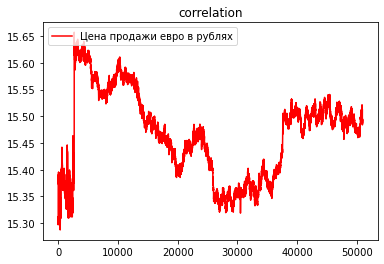

In [15]:
#Посмотрим на графике наши значения
plt.plot(spread, 'r-', label='Цена продажи евро в рублях')
# выведем легенды 
plt.legend(loc='upper left')
 
# добавим заголовок 
plt.title('spread')
 
# покажем график
plt.show()

In [ ]:

lasttick=mt5.symbol_info_tick("GBPUSD")
